# MNE data structure exploration notebook

In this notebook, we explore the possibilities of MNE. MNE is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more. It does not have a direct link to the paper but the expertise gained here is used in the paper.

This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in `bci-master-thesis/experimental-notebooks/CLA-dataset-exploration-notebook.ipynb`.

For this MNE portion we used some of the tips and code samples from Richard Höchenberger's workshop on MNE Python:
- [Pybrain: M/EEG analysis with MNE Python](https://www.youtube.com/watch?v=t-twhNqgfSY)

## Table of Contents

- Checking requirements
    - Correct anaconda environment
    - Correct module access
    - Correct file access
- Loading in data
- Finding important markers
    - Loop for retreiving important markers
    - Analysing important markers
    - Plotting important markers
- Plotting raw EEG data with MNE

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
print("Active environment: "+ os.environ['CONDA_DEFAULT_ENV'])
print("Correct environment: " + str(os.environ['CONDA_DEFAULT_ENV'] == "bci-master-thesis"))

Active environment: bci-master-thesis
Correct environment: True


<hr>

### Correct module access

The following codeblock will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load in the data. The data is provided as `.mat` files and thus originally meant for use with MATLAB. However, thanks to the written `CLA_dataset` util file we can easily get the MNE raw data from it.

Please specify the filename in the below codeblock. For more info on which variants are available, please look at the `bci-master-thesis/code/data/CLA/README.md` file.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'

In [4]:
####################################################
# CHOOSING DATA RECORD
####################################################

# You can specify the data file to use here, per default it is CLASubjectA1601083StLRHand
data_file_name = "CLASubjectA1601083StLRHand"

Markers present: {0: 476168, 1: 61490, 2: 69202, 3: 64740}


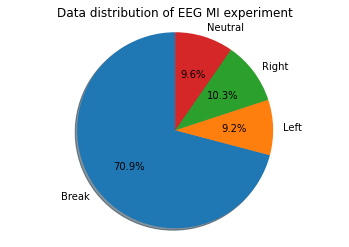

In [5]:
####################################################
# MARKERS DATA DISTRIBUTION
####################################################

# Save the markers from the raw matlab data
data_markers = CLA_dataset.get_raw_matlab_data(data_file_name).marker

# Show labels overview
unique, counts = np.unique(data_markers, return_counts=True)
count_dict = dict(zip(unique, counts))
print("Markers present: " + str(count_dict))

# Make pie chart out of data
labels = 'Break', 'Left', 'Right', 'Neutral'
sizes = [count_dict[0], count_dict[1], count_dict[2], count_dict[3]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')
plt.title("Data distribution of EEG MI experiment")
plt.show()

# Cleaning up redundant variables from this codeblock
del unique
del counts
del fig
del ax
del count_dict
del labels
del sizes

In [6]:
####################################################
# MEN DATA
####################################################

# Load in the file as MNE
mne_raw = CLA_dataset.get_raw_mne_data(data_file_name)

# Show the info
mne_raw.info

Opening raw data file ../data/CLA/CLASubjectA1601083StLRHand_raw.fif...
    Range : 0 ... 671599 =      0.000 ...  3357.995 secs
Ready.


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 21 EEG
 custom_ref_applied: False
 description: Data from ../data/CLA/CLASubjectA1601083StLRHand.mat | age 25| ...
 dig: 24 items (3 Cardinal, 21 EEG)
 experimenter: Kaya et al.
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2016-01-08 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 200.0 Hz
 subject_info: 2 items (dict)
>

<hr><hr>

## Finding important markers

Since the data is one continuous stream of EEG data and we have the marker for each `hertz` / datapoint, it might be a good idea to note the indexes at which these markers change. This will give us an idea of where the data changes from stimulus to stimulus.

### Loop for retreiving important markers

The following loop will collect all important markers from the dataset.

In [7]:
####################################################
# VALIDATING CORRECT LOADING OF MARKERS
####################################################

print("First 5: " + str(data_markers[:5]))

print("Marker size equal to number of time points: " + str(len(data_markers) == mne_raw.n_times))

First 5: [0 0 0 0 0]
Marker size equal to number of time points: True


In [8]:
####################################################
# MARKERS DATA DISTRIBUTION
####################################################

class ImportantMarker:
    def __init__(self, mark, old_mark, start_idx, end_idx):
        self.mark = mark
        self.old_mark = old_mark
        self.start_idx = start_idx
        self.end_idx = end_idx

In [9]:
####################################################
# DETERMINING IMPORTANT MARKERS
####################################################

# Initial values
important_markers = []
new_mark = old_mark = start_idx = end_indx = -1

for idx, marker in enumerate(data_markers):
    # Initial values
    if (start_idx == -1):
        start_idx = idx
        new_mark = old_mark = marker
        
    # Change of marker
    if (marker != new_mark):
        # Save marker
        end_indx = idx - 1
        important_markers.append(ImportantMarker(new_mark, old_mark, start_idx, end_indx))
        
        # Start new marker
        old_mark = new_mark
        new_mark = marker
        start_idx = idx
        
# End of loop, create last record if needed
if (start_idx > end_indx):
    # Save marker
    end_indx = idx
    important_markers.append(ImportantMarker(new_mark, old_mark, start_idx, end_indx))
        
# Cleaning up redundant variables from this codeblock
del new_mark
del old_mark
del start_idx
del end_indx
del idx
del marker

<hr>

### Analysing important markers

Below we perform some basic analysis on the data gathered from the important markers and try to validate they make sense.

In [10]:
####################################################
# VIEWING IMPORTANT MARKERS
####################################################

# View first 5
for important_marker in important_markers[:5]:
    print(f"Starting on {important_marker.start_idx} we changed from {important_marker.old_mark} to {important_marker.mark} Which lasted untill {important_marker.end_idx}")
    
print(f"\n\n... A total of {len(important_markers)} important markers ...\n\n")

# View last 5
for important_marker in important_markers[-5:]:
    print(f"Starting on {important_marker.start_idx} we changed from {important_marker.old_mark} to {important_marker.mark} Which lasted untill {important_marker.end_idx}")
    
# Show labels overview
unique, counts = np.unique([important_marker.mark for important_marker in important_markers], return_counts=True)
count_dict = dict(zip(unique, counts))
print("\n\nImportant markers distribution: " + str(count_dict))

# Determine time between marks
print("\n\nTime that a marker is shown, an action (mark 1, 2 or 3) should be 1 second, the short pause (mark 0) anywhere between 1.5-2.5 seconds")
print(f"Time that marker {important_markers[200].mark} is shown: {(important_markers[200].end_idx - important_markers[200].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[201].mark} is shown: {(important_markers[201].end_idx - important_markers[201].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[202].mark} is shown: {(important_markers[202].end_idx - important_markers[202].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[203].mark} is shown: {(important_markers[203].end_idx - important_markers[203].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[204].mark} is shown: {(important_markers[204].end_idx - important_markers[204].start_idx)/ mne_raw.info['sfreq']} sec")
print(f"Time that marker {important_markers[205].mark} is shown: {(important_markers[205].end_idx - important_markers[205].start_idx)/ mne_raw.info['sfreq']} sec")

# Delete unusued variables
del count_dict
del counts
del unique
del important_marker

Starting on 0 we changed from 0 to 0 Which lasted untill 37271
Starting on 37272 we changed from 0 to 3 Which lasted untill 37474
Starting on 37475 we changed from 3 to 0 Which lasted untill 37782
Starting on 37783 we changed from 0 to 3 Which lasted untill 37985
Starting on 37986 we changed from 3 to 0 Which lasted untill 38369


... A total of 1921 important markers ...


Starting on 667619 we changed from 3 to 0 Which lasted untill 667936
Starting on 667937 we changed from 0 to 2 Which lasted untill 668139
Starting on 668140 we changed from 2 to 0 Which lasted untill 668444
Starting on 668445 we changed from 0 to 3 Which lasted untill 668647
Starting on 668648 we changed from 3 to 0 Which lasted untill 671599


Important markers distribution: {0: 961, 1: 302, 2: 340, 3: 318}


Time that a marker is shown, an action (mark 1, 2 or 3) should be 1 second, the short pause (mark 0) anywhere between 1.5-2.5 seconds
Time that marker 0 is shown: 2.015 sec
Time that marker 1 is shown: 1.01 se

<hr>

### Plotting important markers

When plotting the evolution of these important markers it becomes clear that the stimulus is shown for 1 second (200 Hz) and the screen is blank for about 1.5 seconds (300 Hz).

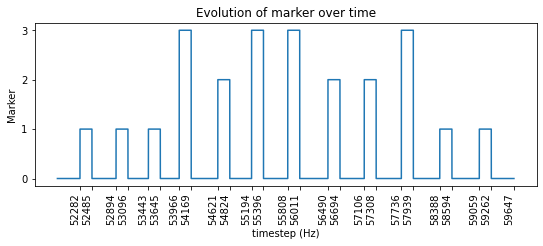

In [11]:
####################################################
# PLOTTING IMPORTANT MARKERS
####################################################

# Open plot inline
%matplotlib inline

# Data for plotting
subset_important_markers = important_markers[50:75]

# Setup canvas
plt.rcParams["figure.figsize"] = (9,3)

# Plotting code
x = sum([[x.start_idx, x.end_idx] for x in subset_important_markers], [])
y = sum([[y.mark, y.mark] for y in subset_important_markers], [])

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='timestep (Hz)', ylabel='Marker',
       title='Evolution of marker over time')

# Only show every 1 in 2 x points
plt.xticks(x[1::2])
plt.yticks([0, 1, 2, 3])
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()
 
# Cleaning up redundant variables from this codeblock
del subset_important_markers
del fig
del ax
del x
del y

# Reset canvas
plt.rcParams.update(plt.rcParamsDefault)

<hr><hr>

## Plotting raw EEG data with MNE

Now that we have the `EMG RawArray object` and know the timestep of marker changes we can start making some interesting MNE plots. We will try this in what follows. We followed the [MNE documentation tutorials for this](https://mne.tools/dev/auto_tutorials/intro/10_overview.html). We note that the base data in the raw object stores the EEG in volts, not microvolts as originally in the matlab CLA dataset. The conversion to volt was done by multuplying with $10e^{-6}$

In [14]:
####################################################
# PLOTTING MNE DATA
####################################################

# Plot inline or in popup
# %matplotlib inline
%matplotlib qt 

# Show some plots
mne_raw.plot_psd(fmax=50)
mne_raw.plot(duration=5, n_channels=30)

print("plotting done")

Effective window size : 10.240 (s)
Opening raw-browser...
plotting done
